# Simulation of Quantum Key Distribution


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, IBMQ, transpile
provider = IBMQ.load_account()

In [2]:
def quantum_random_no(length : int):
    """generates random bit array of given length using IBM quantum
    
    parameters: 
        length: length of bit array
        
    returns: 
        random_bits: random bit array
    """
    
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.measure_all()
    
    backend = provider.get_backend('ibmq_lima')
    qc = transpile(qc, backend)
    job = backend.run(qc, shots=length, memory = True)
    result = job.result()
    string = result.get_memory()
    
    random_bits = np.array(string, dtype=np.int32)
    return random_bits

# RANDOM_BIT_STRING = quantum_random_no(4000)
RANDOM_BIT_STRING = np.load('random_armonk_4000.npy')

In [3]:
# 2.  GOODNESS OF THESE RANDOM NUMBERS
# a) count number of zeros and ones should be greater than 0.95

def bits_count(bit_string):
    count_0 = 0
    count_1 = 0
    length = len(bit_string)
    for i in range(0, length, 1):
        if bit_string[i] == 0:
            count_0 = count_0 + 1
        elif bit_string[i] == 1:
            count_1 = count_1 + 1
    if 1.05 > count_0/count_1 > 0.95:
        print(True)
    return [count_0/length , count_1/length , np.round(count_0/count_1,3)]

bits_count(RANDOM_BIT_STRING)

True


[0.51175, 0.48825, 1.048]

True
True


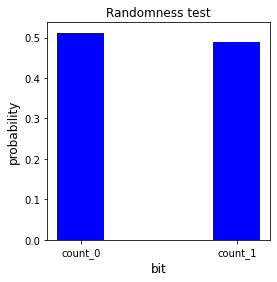

In [4]:
data = {'count_0':bits_count(RANDOM_BIT_STRING)[0], 'count_1':bits_count(RANDOM_BIT_STRING)[1]}
bit = list(data.keys())
counts = list(data.values())
  
fig = plt.figure(figsize = (4,4))
 
# creating the bar plot
plt.bar(bit, counts, color ='blue', width = 0.3)
 
plt.xlabel("bit", fontsize = 12)
plt.ylabel("probability", fontsize = 12)
plt.title("Randomness test", fontsize = 12)
plt.savefig('0-1.png')
plt.show()

In [5]:
# b) frequency of getting 00, 01, 10 and 11

def frequency(bit_string):
    count_00 = 0
    count_01 = 0
    count_10 = 0
    count_11 = 0
    length = len(bit_string)
    for i in range(0, length-1, 1):
        if bit_string[i] == 0 and bit_string[i+1] == 0:
            count_00 = count_00 + 1
        if bit_string[i] == 0 and bit_string[i+1] == 1:
            count_01 = count_01 + 1
        if bit_string[i] == 1 and bit_string[i+1] == 0:
            count_10 = count_10 + 1
        if bit_string[i] == 1 and bit_string[i+1] == 1:
            count_11 = count_11 + 1
    total_count = count_00 + count_01 + count_10 + count_11        
    return count_00, count_01, count_10, count_11
    
frequency(RANDOM_BIT_STRING)

(1041, 1006, 1006, 946)

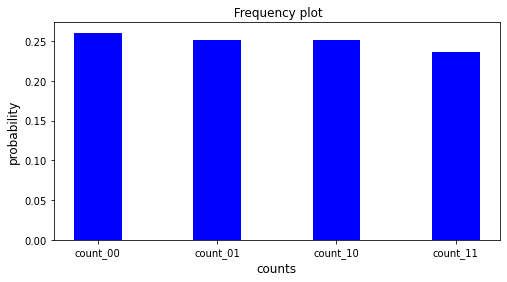

In [6]:
#Probabilty plot

total_count = frequency(RANDOM_BIT_STRING)[0] + frequency(RANDOM_BIT_STRING)[1] + frequency(RANDOM_BIT_STRING)[2] + frequency(RANDOM_BIT_STRING)[3]
data = {'count_00':frequency(RANDOM_BIT_STRING)[0]/total_count, 'count_01':frequency(RANDOM_BIT_STRING)[1]/total_count, 
        'count_10':frequency(RANDOM_BIT_STRING)[2]/total_count,'count_11':frequency(RANDOM_BIT_STRING)[3]/total_count}

counts = list(data.keys())
probability = list(data.values())
  
fig = plt.figure(figsize = (8, 4))
 
# creating the bar plot
plt.bar(counts, probability, color ='blue',
        width = 0.4)
plt.xlabel("counts", fontsize = 12)
plt.ylabel("probability", fontsize = 12)
plt.title(" Frequency plot", fontsize = 12)
plt.savefig('frequencies.png')
plt.show()

In [7]:
# 3. Splitting into 4 parts :  Alice's basis, Alice's data, Bob's basis and Eve's basis

def data_split(random_bit_string):
    bit_length = len(random_bit_string)//4
    Alice_basis = list(random_bit_string[0: bit_length])
    Alice_data = list(random_bit_string[bit_length:2*bit_length])
    Bob_basis = list(random_bit_string[2*bit_length:3*bit_length])
    Eve_basis = list(random_bit_string[3*bit_length:4*bit_length])
    return Alice_basis, Alice_data, Bob_basis, Eve_basis

In [8]:
# 4. GENERATION OF Alice'S sifted DATA

def alice_data(random_bit_string):
    Alice_basis, Alice_data, Bob_basis, _ = data_split(random_bit_string)
    Alice_sifted_data = []
    #Sifted_basis = []
    for j in range(0,len(random_bit_string)//4,1):
        if Alice_basis[j] == Bob_basis[j]:
            Alice_sifted_data.append(Alice_data[j])
            
    return Alice_sifted_data

In [9]:
# 5. Condition for measurement of Eve_data

def eve_data(perc_measured, random_bit_string):
    Alice_basis, Alice_data, _, Eve_basis = data_split(random_bit_string)
    Eve_data = []
    for k in range(0,1000,1):
        n = np.random.rand()   #change it to qiskit
        if n <= perc_measured:
            if Alice_basis[k] == Eve_basis[k]:
                Eve_data.append(Alice_data[k])

            if Alice_basis[k] != Eve_basis[k]:
                l = np.random.randint(0,1)  #change it to qiskit
                Eve_data.append(l)


        if n > perc_measured:
            Eve_data.append(7)
    return Eve_data

In [10]:
# 6. Bob's data in presence of Eve
def bob_data(perc_measured, random_bit_string):
    Bob_data = []
    
    Alice_basis, Alice_data, Bob_basis, _ = data_split(random_bit_string)
    Eve_data = eve_data(perc_measured, random_bit_string)

    for j in range(0,len(random_bit_string)//4,1):
            if (Alice_basis[j] == Bob_basis[j]) and (Eve_data[j] == 7):
                    Bob_data.append(Alice_data[j])
                    
            if (Alice_basis[j] == Bob_basis[j]) and (Eve_data[j] != 7):     
                    Bob_data.append(Eve_data[j])
                    
    return Bob_data

In [11]:
def eve_data2(perc_measured, random_bit_string):
    Eve_data2 = []
    
    Alice_basis, Alice_data, Bob_basis, _ = data_split(random_bit_string)
    Eve_data = eve_data(perc_measured, random_bit_string)

    for j in range(0,len(random_bit_string)//4,1):
            if (Alice_basis[j] == Bob_basis[j]) and (Eve_data[j] == 7):
                    Eve_data2.append(np.random.randint(0,1))  #change it to qiskit
                    
            if (Alice_basis[j] == Bob_basis[j]) and (Eve_data[j] != 7):     
                    Eve_data2.append(Eve_data[j])
                    
    return Eve_data2

In [12]:
# 7. Difference in Alice_data and Bob_data2 as percentage of Eve's measurement(n) increases

def fidelity(perc_measured, random_bit_string):
    Alice_data = alice_data(random_bit_string)
    Bob_data = bob_data(perc_measured, random_bit_string)
    
    fid = 0.0
    for i in range(0, len(Bob_data), 1):
        if Alice_data[i] == Bob_data[i]:
            fid += 1
    perc_fid = fid/len(Bob_data)
    return perc_fid

fidelity(1.0, RANDOM_BIT_STRING)

0.722753346080306

In [13]:
# 7. Difference in Alice_data and Eve_data as percentage of Eve's measurement(n) increases

def fidelity2(perc_measured, random_bit_string):
    Alice_data = alice_data(random_bit_string)
    Eve_data2 = eve_data2(perc_measured, random_bit_string)
    fid = 0.0
    for i in range(0, len(Alice_data), 1):
        if Alice_data[i] == Eve_data2[i]:
            fid += 1
    perc_fid = fid/len(Eve_data2)
    return perc_fid

fidelity2(1.0, RANDOM_BIT_STRING)

0.7304015296367112

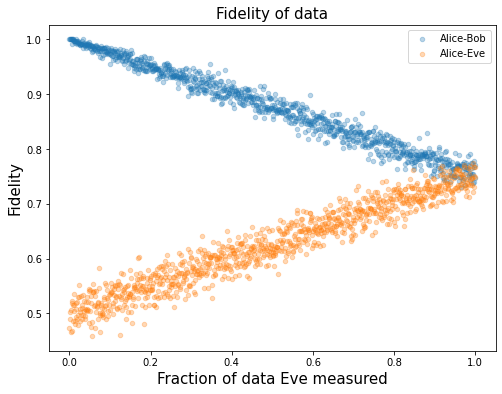

In [14]:
# 8. Plot of fidelity

def fidelity_plot(random_bit_string):
    perc_measured_vals = np.linspace(0,1,1000)
    fid_vals_AB = []
    fid_vals_AE = []
    for i in range(0, len(perc_measured_vals), 1):
        fid_vals_AB.append(fidelity(perc_measured_vals[i], random_bit_string))
        fid_vals_AE.append(fidelity2(perc_measured_vals[i], random_bit_string))

    plt.figure(figsize = (8,6))
    plt.scatter(perc_measured_vals, fid_vals_AB,label='Alice-Bob', s =20, alpha = 0.30)
    plt.scatter(perc_measured_vals, fid_vals_AE,label='Alice-Eve', s =20, alpha = 0.30)    
    plt.xlabel('Fraction of data Eve measured', fontsize = 15)
    plt.ylabel('Fidelity', fontsize = 15)
    plt.legend(fontsize = 10)
    plt.title('Fidelity of data', fontsize = 15)
    
    plt.savefig('Bob-Eve.png')
    plt.show()
    
fidelity_plot(RANDOM_BIT_STRING)

In [15]:
alicedata = alice_data(RANDOM_BIT_STRING)
alice_data2 = np.append(alicedata, np.zeros(11 - len(alicedata) + (len(alicedata)//11)*11))

In [16]:
def ham11(data):
    data = data.reshape(1,11)
    count_2 = 1
    data_p = np.zeros([1,16])
    for i in range(1,16,1):
        if np.log2(i)/1 == np.log2(i)//1:
            data_p[0,i] = 0
            count_2 += 1
        else:
            data_p[0,i]= data[0,i - count_2]
            m= np.int32(data_p.reshape(4,4))
    m[0,1] = 0
    m[0,2] = 0
    m[1,0] = 0
    m[2,0] = 0
    for j in range(0, 4, 1):
        m[0,1] = m[0,1] ^ m[j,1] ^ m[j,3]
        m[0,2] = m[0,2] ^ m[j,2] ^ m[j,3]
        m[1,0] = m[1,0] ^ m[1,j] ^ m[3,j]
        m[2,0] = m[2,0] ^ m[2,j] ^ m[3,j]            
    return m[0,1], m[0,2], m[1,0], m[2,0]

In [17]:
def hamcod(d):
    parity_array = []
    blocks = np.array_split(d,len(d)/11)
    for i in range(len(blocks)):
        parity_array.append(ham11(blocks[i]))
    parity_array = np.array(parity_array).flatten()
    return parity_array

In [18]:
parity_bits = hamcod(alice_data2)

In [19]:
def error_fixer(mat):
    mat2 = mat.copy()
    mat2[0,1] = 0
    mat2[0,2] = 0
    mat2[1,0] = 0
    mat2[2,0] = 0
    for j in range(0, 4, 1):
        mat2[0,1] = mat2[0,1] ^ mat2[j,1] ^ mat2[j,3]
        mat2[0,2] = mat2[0,2] ^ mat2[j,2] ^ mat2[j,3]
        mat2[1,0] = mat2[1,0] ^ mat2[1,j] ^ mat2[3,j]
        mat2[2,0] = mat2[2,0] ^ mat2[2,j] ^ mat2[3,j]            

    errors = np.zeros([4,4])
    for i in range(0,4,1):
        for j in range(0,4,1):
            errors[i,j] = mat[i,j] ^ mat2[i,j]
    x = 0
    y = 0
    for i in range(0,4,1):
        for j in range(0,4,1):
            if errors[i,j] == 1:
                x +=i
                y +=j
    mat[x,y] = not mat[x,y]
    return mat

In [20]:
def bob_ham11(bob_data2, parity_bits):
    parity_blocks = np.array_split(parity_bits, len(parity_bits)/4)
    blocks = np.array_split(bob_data2,len(bob_data2)/11)
    
    m_list = np.array([])
    
    for k in range(0,len(bob_data2)//11,1):
        blocks_k = blocks[k].reshape(1,11)
        parity_k = parity_blocks[k]
        count_2 = 1
        data_p = np.zeros([1,16])
        for i in range(1,16,1):
            if np.log2(i)/1 == np.log2(i)//1:
                data_p[0,i] = parity_k[count_2-1]
                count_2 += 1
            else:
                data_p[0,i]= blocks_k[0,i - count_2]
                m = np.int32(data_p.reshape(4,4))
        m = error_fixer(m)
        m = np.delete(m.flatten(),[0,1,2,4,8])
        
        m_list = np.append(m_list,m)
    return m_list

In [21]:
def eve_ham11(eve_data2, parity_bits):
    parity_blocks = np.array_split(parity_bits, len(parity_bits)/4)
    blocks = np.array_split(eve_data2,len(eve_data2)/11)
    
    m_list = np.array([])
    
    for k in range(0,len(eve_data2)//11,1):
        blocks_k = blocks[k].reshape(1,11)
        parity_k = parity_blocks[k]
        count_2 = 1
        data_p = np.zeros([1,16])
        for i in range(1,16,1):
            if np.log2(i)/1 == np.log2(i)//1:
                data_p[0,i] = parity_k[count_2-1]
                count_2 += 1
            else:
                data_p[0,i]= blocks_k[0,i - count_2]
                m = np.int32(data_p.reshape(4,4))
        m = error_fixer(m)
        m = np.delete(m.flatten(),[0,1,2,4,8])
        
        m_list = np.append(m_list,m)
    return m_list

In [22]:
def bob_plot(fraction):
    bobdata = bob_data(fraction,RANDOM_BIT_STRING)
    whole_11 = np.zeros(11 - len(bobdata) + (len(bobdata)//11)*11)
    bob_data2 = np.append(bobdata, whole_11)

    error_correc_b = bob_ham11(bob_data2, parity_bits)[:-len(whole_11)]
    alice_data_original = alice_data2[:-len(whole_11)]
    

    return np.mean(error_correc_b == alice_data_original), np.mean(bobdata == alice_data_original)

In [23]:
new_fid_b = np.array([bob_plot(fraction) for fraction in np.linspace(0,1,1000)])

In [24]:
from scipy.optimize import curve_fit

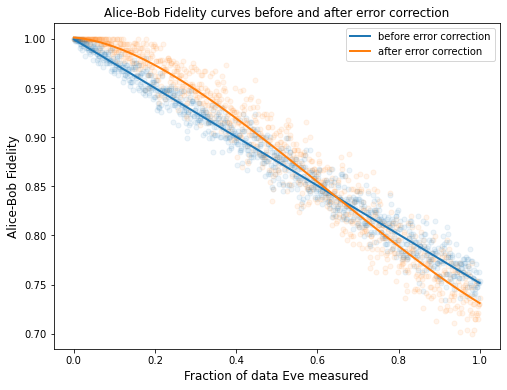

In [25]:
plt.figure(figsize =(8,6))
plt.scatter(np.linspace(0,1,1000), new_fid_b[:,0], color='tab:orange', alpha = 0.08,s=25)

fitstart = 175

plt.scatter(np.linspace(0,1,1000), new_fid_b[:,1], color='tab:blue', alpha = 0.08,s=25)
def lin(x,m,n):
    return m*x + n
constants = curve_fit(lin, np.linspace(0,1,1000), new_fid_b[:,1])
m_fit = constants[0][0]
n_fit = constants[0][1]

fit1 = []
for i in np.linspace(0,1,1000):
    fit1.append(lin(i, m_fit, n_fit))
    

plt.plot(np.linspace(0,1,1000), fit1, label='before error correction', linewidth =2)
def linear2(x,a,b,c,d,e,f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x**1 + f
constants = curve_fit(linear2, np.linspace(0,1,1000), new_fid_b[:,0])

fit2 = []
for i in np.linspace(0,1,1000):
    fit2.append(linear2(i, *constants[0]))
    
plt.plot(np.linspace(0,1,1000), fit2, label='after error correction',linewidth=2)
plt.title("Alice-Bob Fidelity curves before and after error correction",fontsize = 12)
plt.xlabel('Fraction of data Eve measured', fontsize = 12)
plt.ylabel('Alice-Bob Fidelity', fontsize = 12)
plt.legend(fontsize = 10)
plt.savefig('Alice-Bob Fidelity.png')

In [26]:
def eve_plot(fraction):
    evedata = eve_data2(fraction,RANDOM_BIT_STRING)
    whole_11 = np.zeros(11 - len(evedata) + (len(evedata)//11)*11)
    eve_data3 = np.append(evedata, whole_11)

    error_correc_e = eve_ham11(eve_data3, parity_bits)[:-len(whole_11)]
    alice_data_original = alice_data2[:-len(whole_11)]
    
    return np.mean(error_correc_e == alice_data_original), np.mean(evedata == alice_data_original)

In [27]:
new_fid_e= np.array([eve_plot(fraction) for fraction in np.linspace(0,1,1000)])

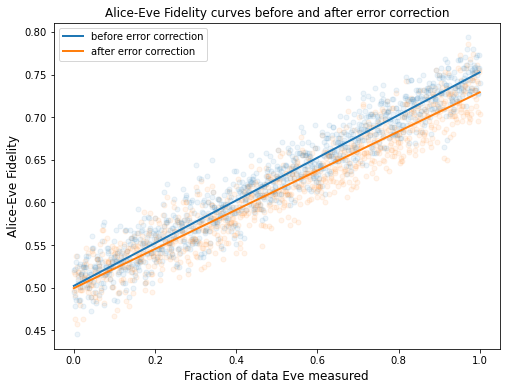

In [28]:
plt.figure(figsize = (8,6))  
def linear(x,a,b):
    return a*x + b
constants = curve_fit(linear, np.linspace(0,1,1000), new_fid_e[:,0])
a_fit = constants[0][0]
b_fit = constants[0][1]

fit = []
for i in np.linspace(0,1,1000):
    fit.append(linear(i, a_fit, b_fit))
      
plt.scatter(np.linspace(0,1,1000), new_fid_e[:,0], color='tab:orange', alpha = 0.08, s = 25)
plt.scatter(np.linspace(0,1,1000), new_fid_e[:,1], color='tab:blue', alpha = 0.08, s = 25)    

def linear2(x,c,d):
    return c*x + d
constants = curve_fit(linear2, np.linspace(0,1,1000), new_fid_e[:,1])
c_fit = constants[0][0]
d_fit = constants[0][1]

fit3 = []
for i in np.linspace(0,1,1000):
    fit3.append(linear2(i, c_fit, d_fit))
    
plt.plot(np.linspace(0,1,1000), fit3, label='before error correction',linewidth=2,color='tab:blue')

plt.plot(np.linspace(0,1,1000), fit, label='after error correction',linewidth=2,color='tab:orange')
plt.title("Alice-Eve Fidelity curves before and after error correction",fontsize = 12)
plt.xlabel('Fraction of data Eve measured',fontsize = 12)
plt.ylabel('Alice-Eve Fidelity',fontsize = 12)
plt.legend(fontsize = 10)
plt.savefig('Alice-Eve Fidelity.png')
